In [1]:
# pylint: disable=invalid-name
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


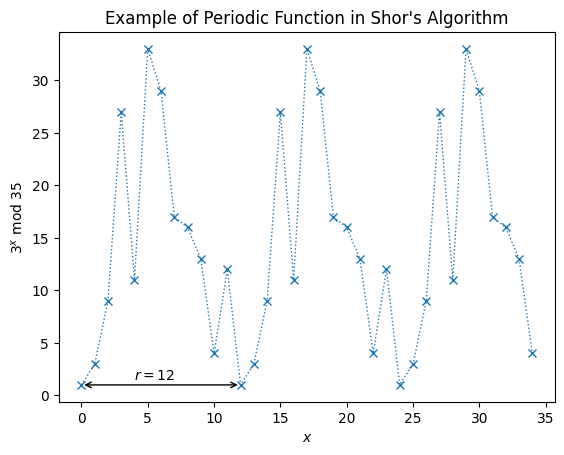

In [2]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

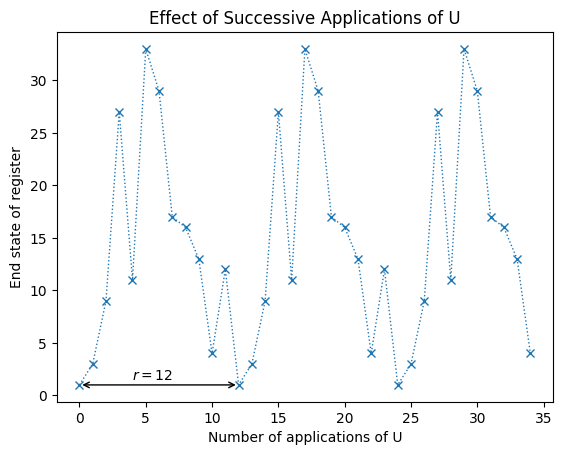

In [3]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

In [4]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [5]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [6]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

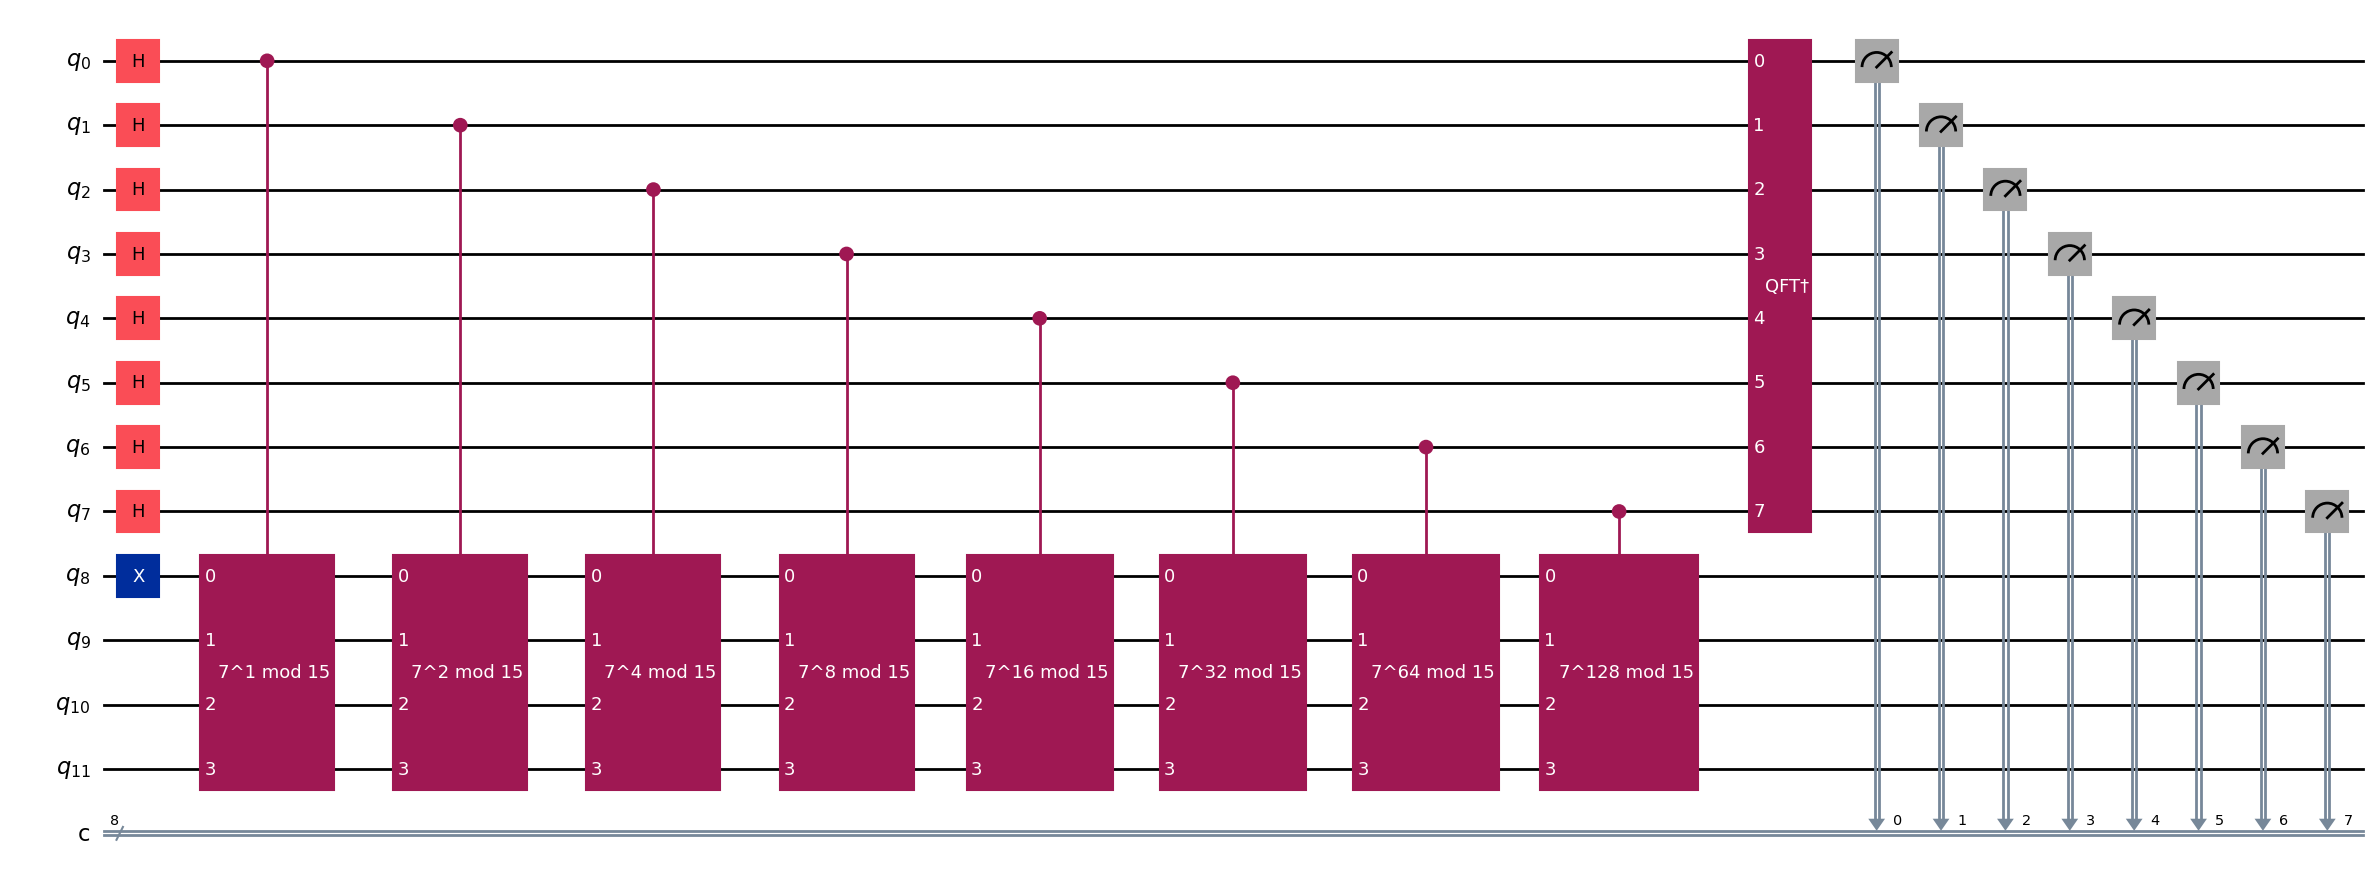

In [7]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1, output='mpl')  # -1 means 'do not fold'

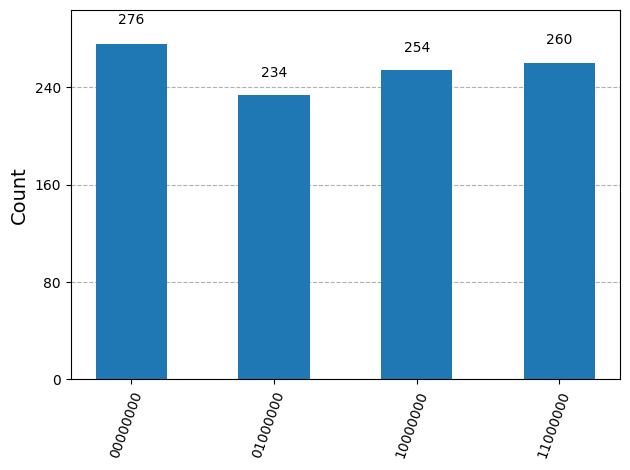

In [8]:
aer_sim = AerSimulator()
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [10]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [11]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [12]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


In [13]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [14]:
a2jmodN(7, 2049, 53)

np.int64(47)

In [15]:
N = 15

In [16]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


In [17]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [18]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = AerSimulator()
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [19]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

Register Reading: 11000000
Corresponding Phase: 0.75


Fraction(3, 4)

In [20]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


In [21]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


In [22]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 2:
Register Reading: 10000000
Corresponding Phase: 0.5
Result: r = 2
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***


In [23]:
# The cell below repeats the algorithm until at least one factor of 15
# is found
assert (3 in guesses) or (5 in guesses)

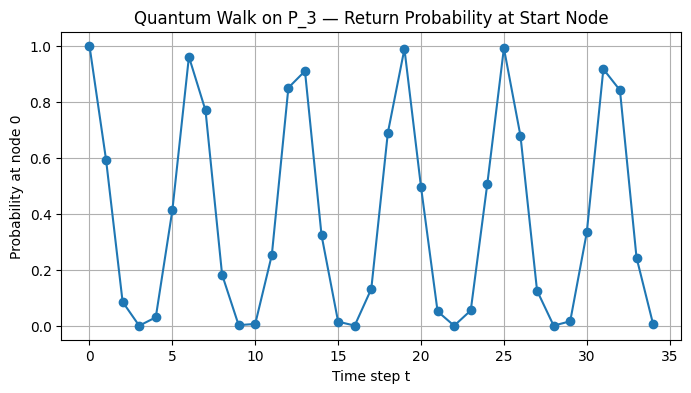

In [24]:
## Find the period of the periodic funciton using the quantum walk
def quantum_walk_period(n_vertices, steps):
    """
    Simulates a discrete-time quantum walk on a path graph P_n and 
    returns the probability of being back at the start node over time.
    
    Parameters:
        n_vertices (int): Number of vertices in the path graph.
        steps (int): Number of time steps to simulate.
    
    Returns:
        times (np.array): Time steps.
        probs (list): Probability of being at the start node at each time step.
    """
    # Create adjacency matrix of path graph P_n
    A = np.zeros((n_vertices, n_vertices))
    for i in range(n_vertices - 1):
        A[i, i+1] = A[i+1, i] = 1

    # Degree matrix and normalized Hermitian adjacency matrix H̃
    D = np.diag([np.sum(row) for row in A])
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    H = D_inv_sqrt @ A @ D_inv_sqrt

    # Diagonalize H for fast simulation
    eigvals, eigvecs = np.linalg.eigh(H)
    
    # Evolution operator U(t) = exp(-iHt)
    def evolution(t):
        return eigvecs @ np.diag(np.exp(-1j * eigvals * t)) @ eigvecs.T

    # Initial state: localized at node 0
    psi0 = np.zeros(n_vertices, dtype=complex)
    psi0[0] = 1.0

    # Simulate the evolution
    times = np.arange(steps)
    probs = []
    for t in times:
        psi_t = evolution(t) @ psi0
        probs.append(np.abs(psi_t[0])**2)  # probability of being back at node 0

    return times, probs

# --- Run the simulation ---
n_vertices = 3  # Number of nodes in the path
steps = 35      # Time steps to simulate

times, probs = quantum_walk_period(n_vertices, steps)

# --- Plot the result ---
plt.figure(figsize=(8,4))
plt.plot(times, probs, marker='o')
plt.title(f"Quantum Walk on P_{n_vertices} — Return Probability at Start Node")
plt.xlabel("Time step t")
plt.ylabel("Probability at node 0")
plt.grid(True)
plt.show()

In [25]:
pip install QuantumRingsLib

Note: you may need to restart the kernel to use updated packages.


In [28]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['mathtext.default'] = 'it'


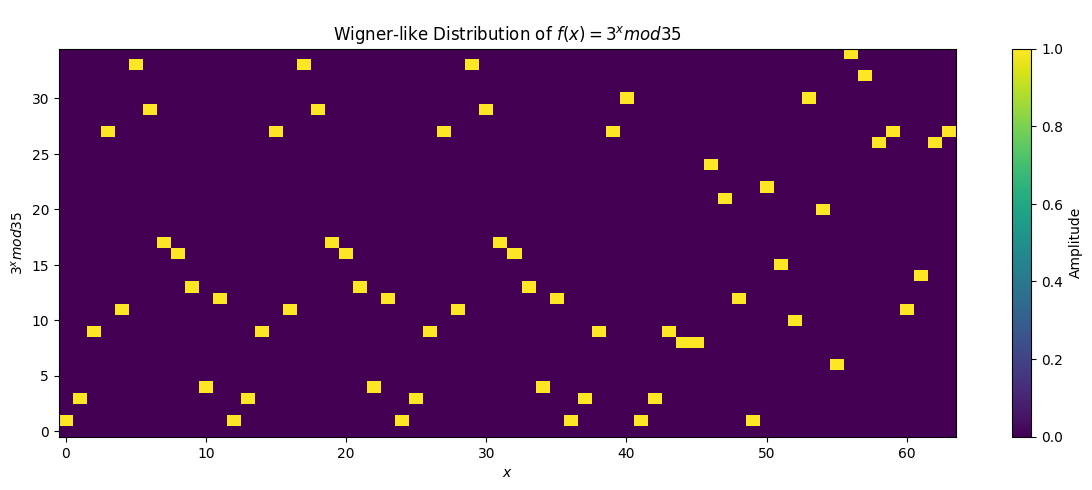

### Detected period: $r = 12$

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Parameters
a = 3
N = 35
num_points = 64

# Compute f(x) = a^x mod N
xvals = np.arange(num_points)
fvals = np.mod(np.power(a, xvals), N)

# --- Period detection: direct method ---
def find_period(fvals):
    start = fvals[0]
    for r in range(1, len(fvals) // 2):
        if np.array_equal(fvals[:r], fvals[r:2*r]):
            return r
    return None

r_detected = find_period(fvals)

# --- Plot ---
wigner_matrix = np.zeros((N, num_points))
for i, fx in enumerate(fvals):
    wigner_matrix[fx, i] += 1

plt.figure(figsize=(12, 5))
plt.imshow(wigner_matrix, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label='Amplitude')
plt.xlabel('$x$')
plt.ylabel(f'${a}^x mod {N}$')
plt.title(f'Wigner-like Distribution of $f(x) = {a}^x mod {N}$')

# Period annotation
if r_detected:
    plt.annotate('', xy=(0, N+1), xytext=(r_detected, N+1),
                 arrowprops=dict(arrowstyle='<->', color='white'))
    plt.text(r_detected / 2, N + 2, f'$r = {r_detected}$', color='white', ha='center')
else:
    print("Period not found.")

plt.tight_layout()
plt.show()

# --- Display output in markdown format ---
if r_detected:
    display(Markdown(f"### Detected period: $r = {r_detected}$"))
else:
    display(Markdown("### Could not detect the period"))


In [44]:
from math import gcd

def shor_from_period(a, N, r):
    # Step 1: Check if r is even
    if r % 2 != 0:
        print("Period is not even, Shor's algorithm fails.")
        return None

    # Step 2: Compute a^(r/2) mod N
    x = pow(a, r // 2, N)
    print(f"→ a^(r/2) mod N = {a}^({r // 2}) mod {N} = {x}")

    # Step 3: Check if x == -1 mod N
    if x == N - 1:
        print("a^(r/2) ≡ -1 mod N → factors won't be found.")
        return None

    # Step 4: Compute gcd(x - 1, N) and gcd(x + 1, N)
    factor1 = gcd(x - 1, N)
    factor2 = gcd(x + 1, N)

    if 1 < factor1 < N:
        print(f"Found factor: gcd({x}-1, {N}) = {factor1}")
    if 1 < factor2 < N:
        print(f"Found factor: gcd({x}+1, {N}) = {factor2}")
    
    if factor1 in [1, N] and factor2 in [1, N]:
        print("No non-trivial factors found.")
        return None

    return (factor1, factor2)


In [45]:
a = 3
N = 35
r = 12  # From the earlier detection

factors = shor_from_period(a, N, r)


→ a^(r/2) mod N = 3^(6) mod 35 = 29
Found factor: gcd(29-1, 35) = 7
Found factor: gcd(29+1, 35) = 5


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def plot_wigner_and_detect_period(a, N, num_points=64):
    """
    Plot a Wigner-like distribution of f(x) = a^x mod N,
    and detect its period visually.

    Parameters:
        a (int): base
        N (int): modulo
        num_points (int): number of x values to compute
    """
    # Step 1: Compute f(x) = a^x mod N
    xvals = np.arange(num_points)
    fvals = np.mod(np.power(a, xvals), N)

    # Step 2: Period detection
    def find_period(fvals):
        start = fvals[0]
        for r in range(1, len(fvals) // 2):
            if np.array_equal(fvals[:r], fvals[r:2*r]):
                return r
        return None

    r_detected = find_period(fvals)

    # Step 3: Wigner-like matrix
    wigner_matrix = np.zeros((N, num_points))
    for i, fx in enumerate(fvals):
        wigner_matrix[fx, i] += 1

    # Step 4: Plot
    plt.figure(figsize=(12, 5))
    plt.imshow(wigner_matrix, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.xlabel('$x$')
    plt.ylabel(f'${a}^x mod {N}$')
    plt.title(f'Wigner-like Distribution of $f(x) = {a}^x mod {N}$')

    # Annotate detected period
    if r_detected:
        plt.annotate('', xy=(0, N+1), xytext=(r_detected, N+1),
                     arrowprops=dict(arrowstyle='<->', color='white'))
        plt.text(r_detected / 2, N + 2, f'$r = {r_detected}$', color='white', ha='center')
    else:
        print("Period not found.")

    plt.tight_layout()
    plt.show()

    # Step 5: Display Markdown summary
    if r_detected:
        display(Markdown(f"### Detected period: $r = {r_detected}$"))
    else:
        display(Markdown("### Could not detect the period"))


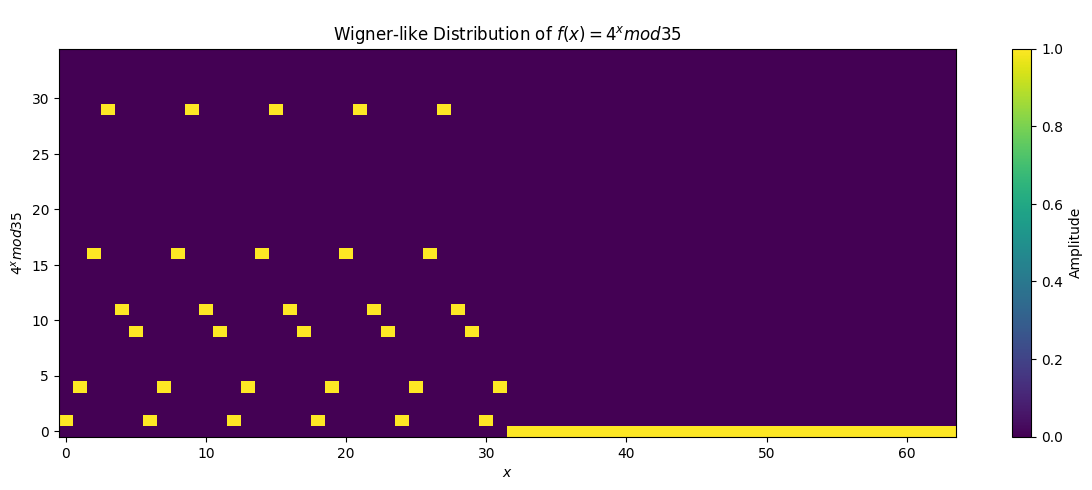

### Detected period: $r = 6$

In [49]:
plot_wigner_and_detect_period(4, 35)

In [50]:
shor_from_period(4, 35, 6)

→ a^(r/2) mod N = 4^(3) mod 35 = 29
Found factor: gcd(29-1, 35) = 7
Found factor: gcd(29+1, 35) = 5


(7, 5)

In [56]:
def plot_wigner_and_shor(a, N, num_points=64):
    """
    Plots a Wigner-like distribution of f(x) = a^x mod N,
    detects the period, and applies classical post-processing of Shor's algorithm.

    Parameters:
        a (int): base
        N (int): number to factor
        num_points (int): number of x values to compute
    """
    # Step 1: Compute f(x) = a^x mod N
    xvals = np.arange(num_points)
    fvals = np.mod(np.power(a, xvals), N)

    # Step 2: Detect period from repeated pattern
    def find_period(fvals):
        start = fvals[0]
        for r in range(1, len(fvals) // 2):
            if np.array_equal(fvals[:r], fvals[r:2*r]):
                return r
        return None

    r = find_period(fvals)

    # Step 3: Plot Wigner-like matrix
    wigner_matrix = np.zeros((N, num_points))
    for i, fx in enumerate(fvals):
        wigner_matrix[fx, i] += 1

    plt.figure(figsize=(12, 5))
    plt.imshow(wigner_matrix, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.xlabel('$x$')
    plt.ylabel(f'${a}^x mod {N}$')
    plt.title(f'Wigner-like Distribution of $f(x) = {a}^x mod {N}$')

    if r:
        plt.annotate('', xy=(0, N+1), xytext=(r, N+1),
                     arrowprops=dict(arrowstyle='<->', color='white'))
        plt.text(r / 2, N + 2, f'$r = {r}$', color='white', ha='center')

    plt.tight_layout()
    plt.show()

    # Step 4: Display detected period
    if r:
        display(Markdown(f"### Detected period: $r = {r}$"))
    else:
        display(Markdown("### Could not detect the period"))
        return

    # Step 5: Shor's classical post-processing
    display(Markdown("### Shor's Algorithm Post-Processing"))

    if r % 2 != 0:
        display(Markdown("- Period is not even → Algorithm fails."))
        return

    x = pow(a, r // 2, N)
    display(Markdown(f"- $a^{{r/2}} mod N = {a}^{{{r // 2}}} mod {N} = {x}$"))

    if x == N - 1:
        display(Markdown("- $a^{{r/2}} \\equiv -1 mod N$ → factors not found."))
        return

    factor1 = gcd(x - 1, N)
    factor2 = gcd(x + 1, N)

    if factor1 not in [1, N]:
        display(Markdown(f"- Found factor: $\\gcd({x}-1, {N}) = {factor1}$"))
    if factor2 not in [1, N]:
        display(Markdown(f"- Found factor: $\\gcd({x}+1, {N}) = {factor2}$"))

    if factor1 in [1, N] and factor2 in [1, N]:
        display(Markdown("- No non-trivial factors found."))
    else:
        display(Markdown(f"### Factor **{factor1}** and **{factor2}**"))


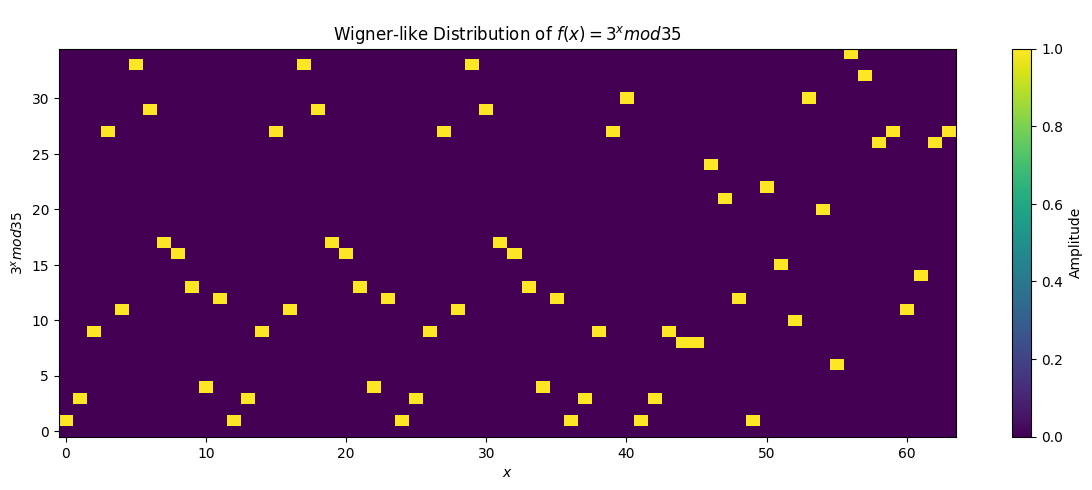

### Detected period: $r = 12$

### 🔍 Shor's Algorithm Post-Processing

- $a^{r/2} mod N = 3^{6} mod 35 = 29$

- Found factor: $\gcd(29-1, 35) = 7$

- Found factor: $\gcd(29+1, 35) = 5$

### Factor **7** and **5**

In [55]:
plot_wigner_and_shor(3, 35)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from math import gcd
import random

def find_period(fvals):
    """ Find the period of the function

    Args:
        fvals (int): the target number

    Returns:
        None
    """
    start = fvals[0]
    for r in range(1, len(fvals) // 2):
        if np.array_equal(fvals[:r], fvals[r:2*r]):
            return r
    return None

def plot_wigner_and_detect_period(a, N, num_points=64, show_plot=True):
    """ plots the winger-like funciton and finds the period

    Args:
        a (int):
        N (int): target number
        num_points (int, optional): _description_. Defaults to 64.
        show_plot (bool, optional): _description_. Defaults to True.

    Returns:
        None
    """
    xvals = np.arange(num_points)
    fvals = np.mod(np.power(a, xvals), N)

    r_detected = find_period(fvals)

    wigner_matrix = np.zeros((N, num_points))
    for i, fx in enumerate(fvals):
        wigner_matrix[fx, i] += 1

    if show_plot:
        plt.figure(figsize=(12, 5))
        plt.imshow(wigner_matrix, cmap='viridis', aspect='auto', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.xlabel('$x$')
        plt.ylabel(f'${a}^x mod {N}$')
        plt.title(f'Wigner-like Distribution of $f(x) = {a}^x mod {N}$')
        if r_detected:
            plt.annotate('', xy=(0, N+1), xytext=(r_detected, N+1),
                         arrowprops=dict(arrowstyle='<->', color='white'))
            plt.text(r_detected / 2, N + 2, f'$r = {r_detected}$', color='white', ha='center')
        else:
            plt.text(num_points / 2, N + 2, "No period found", color='red', ha='center')

        plt.tight_layout()
        plt.show()

    return r_detected

def shor_from_period(a, N, r):
    """ apply shor's algorithm using the given period 

    Args:
        a (int): 
        N (int): target number
        r (int): period
    Returns:
        tuple(factors): the tupple of factors found
    """
    if r % 2 != 0:
        print("Period is not even. Skipping.")
        return None

    x = pow(a, r // 2, N)
    print(f"→ a^(r/2) mod N = {a}^({r // 2}) mod {N} = {x}")

    if x == N - 1 or x == 1:
        print("a^(r/2) ≡ ±1 mod N. Skipping.")
        return None

    factor1 = gcd(x - 1, N)
    factor2 = gcd(x + 1, N)

    factors = set()
    if 1 < factor1 < N:
        print(f"Found factor: gcd({x}-1, {N}) = {factor1}")
        factors.add(factor1)
    if 1 < factor2 < N:
        print(f"Found factor: gcd({x}+1, {N}) = {factor2}")
        factors.add(factor2)

    if not factors:
        print("No non-trivial factors found.")
        return None

    return tuple(factors)

def shors_algorithm_visual(N, max_trials=20, num_points=64):
    """ Factorizes a composite number N using a visual simulation of Shor's algorithm.
    
    Parameters:
        N (int): The composite number to factorize (must be odd and > 2).
        max_trials (int): Maximum number of random values `a` to try.
        num_points (int): Number of values of x to compute for visualizing f(x).

    Returns:
        tuple or None:
            If successful: (factor1, factor2) where factor1 * factor2 == N
            If unsuccessful: None
    """
    if N % 2 == 0:
        return (2, N // 2)

    for _ in range(max_trials):
        a = random.randint(2, N - 2)
        if gcd(a, N) != 1:
            print(f"Lucky guess: gcd({a}, {N}) = {gcd(a, N)}")
            return (gcd(a, N), N // gcd(a, N))

        print(f"Trying a = {a}")
        r = plot_wigner_and_detect_period(a, N, num_points=num_points)
        if r:
            print(f"Detected period r = {r}")
            result = shor_from_period(a, N, r)
            if result:
                display(Markdown(
                    f"""
                    ### Success!
                    - Chosen $a = {a}$
                    - Detected period $r = {r}$
                    - Factors of `{N}` are **{result[0]}** and **{result[1]}**
                    """
                ))
                return result
        else:
            print("Could not detect period.")

    print("Failed to factor within max trials.")
    return None


Trying a = 11


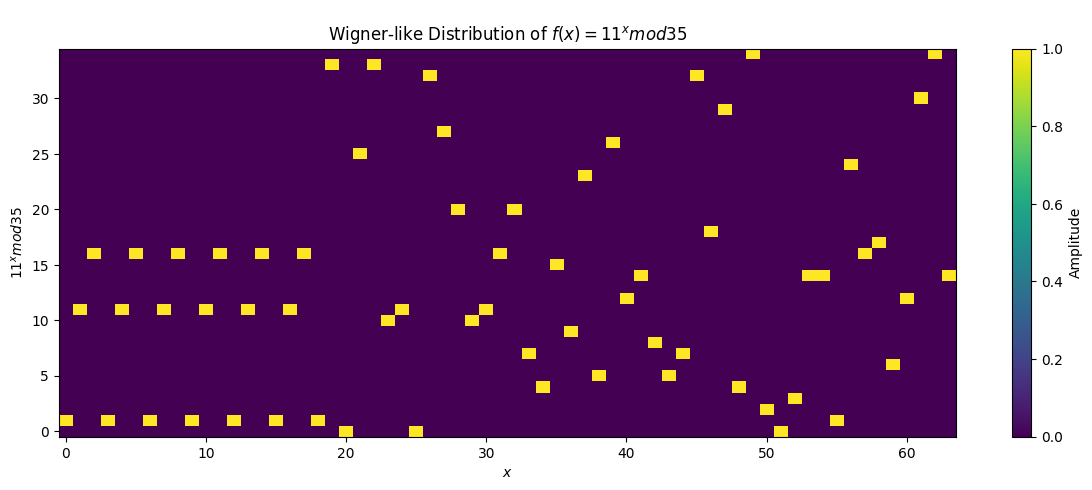

Detected period r = 3
Period is not even. Skipping.
Lucky guess: gcd(7, 35) = 7


(7, 5)

In [58]:
shors_algorithm_visual(35)

Trying a = 136


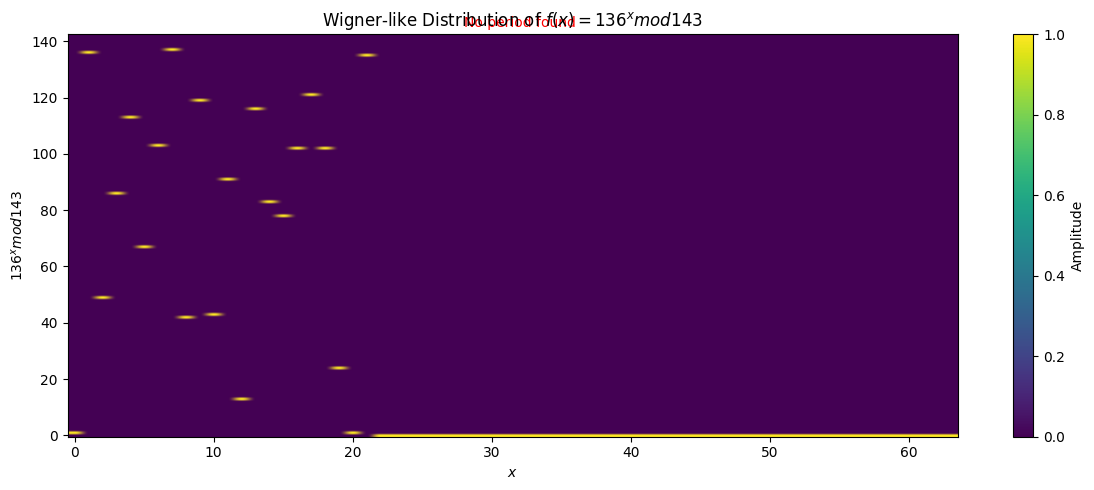

Could not detect period.
Trying a = 106


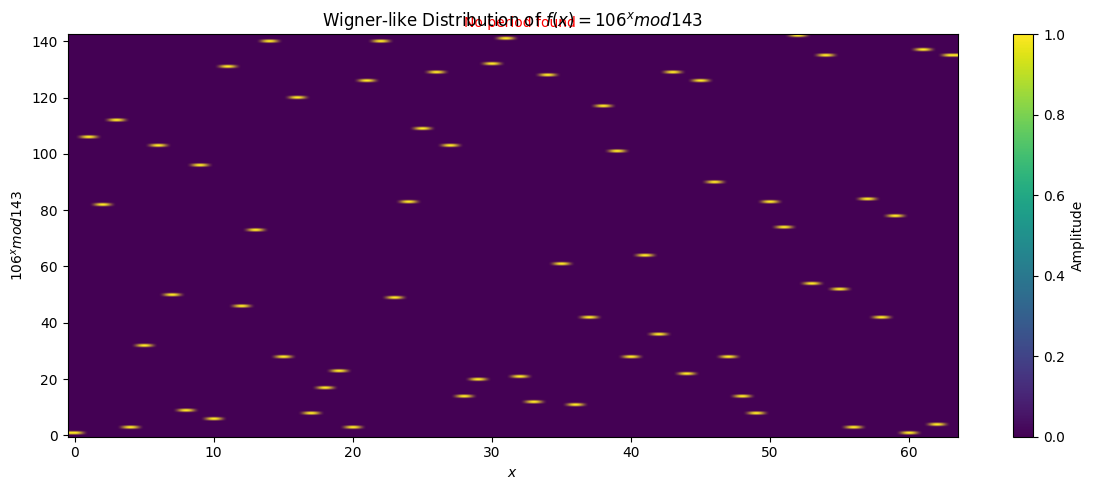

Could not detect period.
Lucky guess: gcd(91, 143) = 13


(13, 11)

In [59]:
shors_algorithm_visual(143)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from math import gcd
import random

def find_period(fvals):
    """Detects the period r of a^x mod N."""
    for r in range(1, len(fvals) // 2):
        if np.array_equal(fvals[:r], fvals[r:2*r]):
            return r
    return None

def plot_wigner_and_detect_period(a, N, num_points=64):
    """Returns the detected period r. Plots only if show_plot=True."""
    xvals = np.arange(num_points)
    fvals = np.mod(np.power(a, xvals), N)
    r_detected = find_period(fvals)
    
    if not r_detected:
        return None

    # Create Wigner-like matrix
    wigner_matrix = np.zeros((N, num_points))
    for i, fx in enumerate(fvals):
        wigner_matrix[fx, i] += 1

    # Plot only if period is valid
    plt.figure(figsize=(12, 5))
    plt.imshow(wigner_matrix, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.xlabel('x')
    plt.ylabel(f'{a}^x mod {N}')
    plt.title(f'Wigner-like Distribution of f(x) = {a}^x mod {N}')
    plt.annotate('', xy=(0, N+1), xytext=(r_detected, N+1),
                 arrowprops=dict(arrowstyle='<->', color='white'))
    plt.text(r_detected / 2, N + 2, f'r = {r_detected}', color='white', ha='center')
    plt.tight_layout()
    plt.show()

    return r_detected

def shor_from_period(a, N, r):
    """Uses the period to try to factor N."""
    if r % 2 != 0:
        return None
    x = pow(a, r // 2, N)
    if x == 1 or x == N - 1:
        return None
    factor1 = gcd(x - 1, N)
    factor2 = gcd(x + 1, N)
    if 1 < factor1 < N:
        return (factor1, N // factor1)
    if 1 < factor2 < N:
        return (factor2, N // factor2)
    return None

def shors_algorithm_visual(N, max_trials=20, num_points=64):
    """
    Attempts to factor N using a Shor-like classical simulation.
    Only displays output and visualization on success.
    """
    if N % 2 == 0:
        return (2, N // 2)

    trial_count = 0
    for a in range(2, N):
        if trial_count >= max_trials:
            break
        if gcd(a, N) != 1:
            continue

        fvals = np.array([pow(a, x, N) for x in range(num_points)])
        r = find_period(fvals)
        if r is None:
            trial_count += 1
            continue

        result = shor_from_period(a, N, r)
        if result:
            plot_wigner_and_detect_period(a, N, num_points)
            display(Markdown(
                f"""
                ### ✅ Success!
                - **Chosen:** $a = {a}$
                - **Detected period:** $r = {r}$
                - **Factors of {N}:** **{result[0]}** and **{result[1]}**
                """
                ))
            return result

        trial_count += 1

    print("Failed to factor within max trials.")
    return None


In [71]:
shors_algorithm_visual(143)


                ### Success!
                - Chosen $a = 4$
                - Detected period $r = 30$
                - Factors of **143** are **11** and **13**
                

(11, 13)